<a href="https://colab.research.google.com/github/Shazaam91/Hate-Speech-Detection-/blob/main/Hate_Speech.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [118]:
#import required libraries
import tensorflow as tf
import csv
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import io
import gzip
import nltk


from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2
nltk.download('punkt')
from collections import Counter
plt.rcParams['font.family'] = 'Noto Sans Sinhala'

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [119]:
#mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [120]:
df = pd.read_csv('sinhala-hate-speech-dataset.csv', encoding='utf-8')

In [121]:
# Display the first few rows
df.head(10)

,id,comment,label
0,1,`හුදෙකලා´ එකේ `ද´ ඇහෙනවද කාටහරි,0
1,2,18ක පෙනුමක් තියෙන්නේ,0
2,3,2020 එනවා කිව්නාට මෙහෙම එයි කියලා හිතුවේ නෑ පට්ට,0
3,4,25 කැල්ල..හම්මෝ..,0
4,5,25 කෙල්ල අයියලගෙ කාලද කොහෙද ඉන්නෙ,1
5,6,25 ක් වගේ ???ඉතින් වැලලියන්,1
6,7,25 ලුක් එක දැකල ඔලුව සවුත්තු උන තරිදු...,0
7,8,25ක පෙනුමක් කියපු කෑල්ලේ ඉදන් බලන එක නතර කලා,0
8,9,33ක් ගුවන්තොටුපළවල ලෝකයේ හිරවෙලා ඉන්නවා ඩුබායි...,0
9,10,5 දෙනා කිව්වෙ මේ පස්දෙනාද..,0


In [122]:
# Basic information about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6345 entries, 0 to 6344
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       6345 non-null   int64 
 1   comment  6345 non-null   object
 2   label    6345 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 148.8+ KB


In [123]:
# Summary statistics
df.describe()

,id,label
count,6345.000000,6345.000000
mean,3173.000000,0.544523
std,1831.788061,0.498053
min,1.000000,0.000000
25%,1587.000000,0.000000
50%,3173.000000,1.000000
75%,4759.000000,1.000000
max,6345.000000,1.000000


In [124]:
# Checking for missing values
df.isnull().sum()

,0
id,0
comment,0
label,0


In [127]:
import re

def clean_text(text):
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'@\w+', '', text)  # Remove mentions
    text = re.sub(r'#\w+', '', text)  # Remove hashtags
    text = re.sub(r'[^A-Za-z\s]', '', text)  # Remove special characters and numbers
    text = text.lower()  # Convert to lowercase
    return text

# Apply cleaning function to all comments
df['cleaned_comment'] = df['comment'].apply(clean_text)


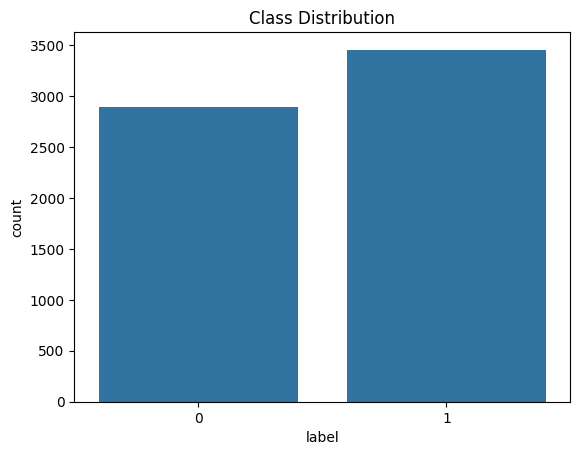

label
1    3455
0    2890
Name: count, dtype: int64


In [128]:
# Plotting the distribution of labels
sns.countplot(x='label', data=df)
plt.title('Class Distribution')
plt.show()

# Print the counts of each class
print(df['label'].value_counts())


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-noto is already the newest version (20201225-1build1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


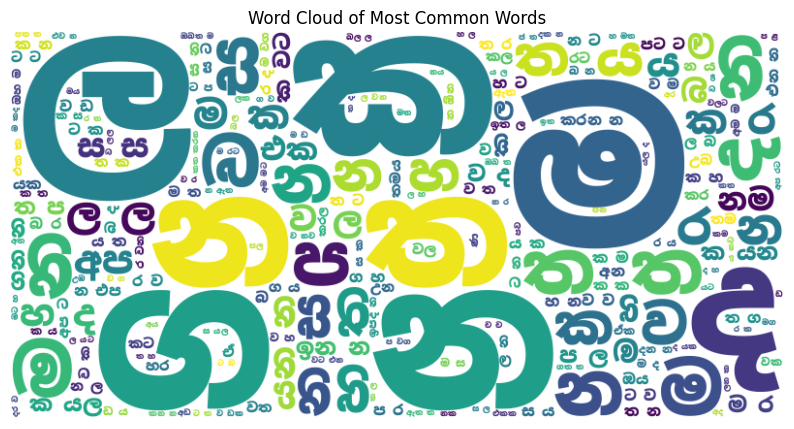

In [129]:
!apt-get install fonts-noto

#import wordcloud
from wordcloud import WordCloud

wordcloud = WordCloud(width=800, height=400, background_color='white', font_path='/content/NotoSansSinhala-Black.ttf').generate(' '.join(df['comment']))

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Most Common Words')
plt.show()


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 108 (l) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 112 (p) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


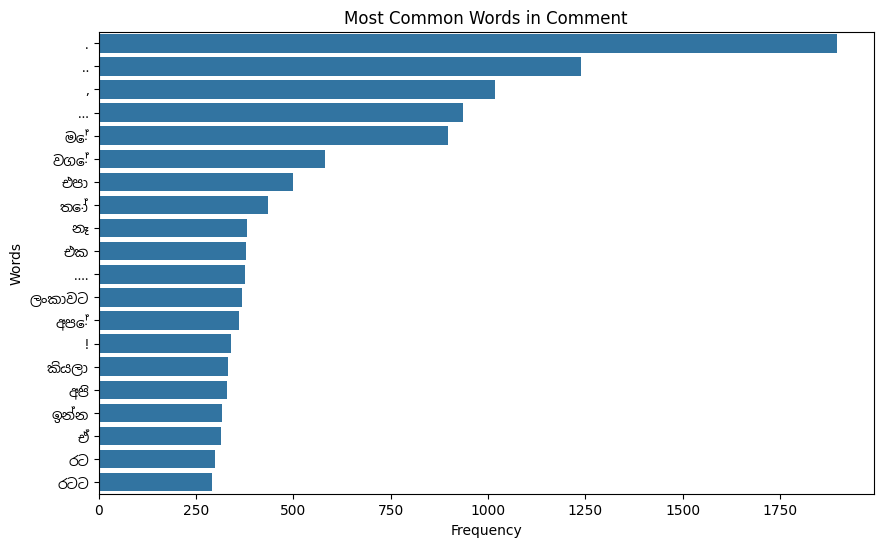

In [130]:
import matplotlib.font_manager as fm
from collections import Counter
from nltk.tokenize import word_tokenize

# Tokenize the posts
df['tokenized'] = df['comment'].apply(word_tokenize)

# Flatten the list of all words
all_words = [word for tokens in df['tokenized'] for word in tokens]

# Frequency distribution of the most common words
word_freq = Counter(all_words)
common_words = word_freq.most_common(20)

# Set the font properties for Sinhala text
sinhala_prop = fm.FontProperties(fname='/usr/share/fonts/truetype/noto/NotoSansSinhala-Regular.ttf')

# Plotting the most common words
plt.figure(figsize=(10, 6))
sns.barplot(x=[word[1] for word in common_words], y=[word[0] for word in common_words])
plt.title('Most Common Words in Comment')  # Title in English
plt.xlabel('Frequency')  # X-axis label in English
plt.ylabel('Words')  # Y-axis label in English
plt.xticks()  # X-ticks in default font (English)
plt.yticks(fontproperties=sinhala_prop, fontsize=10, rotation=0, ha='right')  # Y-ticks in Sinhala font, aligned to the right

plt.show()



In [131]:
from nltk import ngrams

# Create bigrams
bigrams = list(ngrams(all_words, 2))
bigram_freq = Counter(bigrams).most_common(20)

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 108 (l) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 112 (p) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


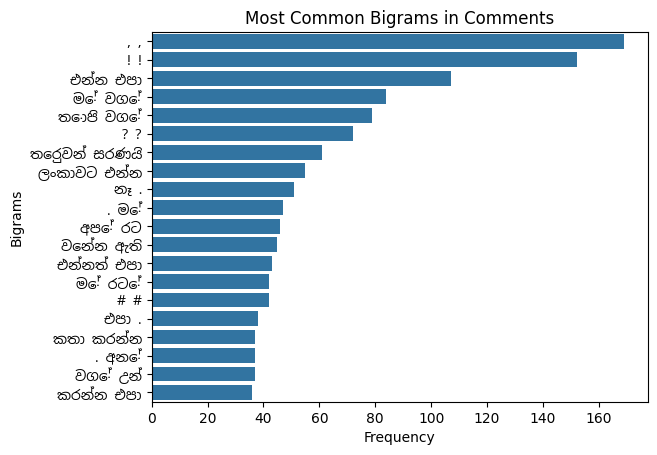

In [132]:
# Tokenize the comment
df['tokenized'] = df['comment'].apply(word_tokenize)

# Flatten the list of all words
all_words = [word for tokens in df['tokenized'] for word in tokens]

# Create bigrams
bigrams = list(ngrams(all_words, 2))
bigram_freq = Counter(bigrams).most_common(20)

# Set the font properties for Sinhala text
sinhala_prop = fm.FontProperties(fname='/usr/share/fonts/truetype/noto/NotoSansSinhala-Regular.ttf')

# Plotting the most common bigrams
sns.barplot(x=[bigram[1] for bigram in bigram_freq], y=[' '.join(bigram[0]) for bigram in bigram_freq])

# Adding title and labels
plt.title('Most Common Bigrams in Comments')  # Title in English
plt.xlabel('Frequency')  # X-axis label in English
plt.ylabel('Bigrams')  # Y-axis label in English

# Adjust y-axis ticks for better visibility
plt.yticks(fontproperties=sinhala_prop, fontsize=10, ha='right', rotation=0)  # Y-ticks in Sinhala font, aligned to the right

plt.show()


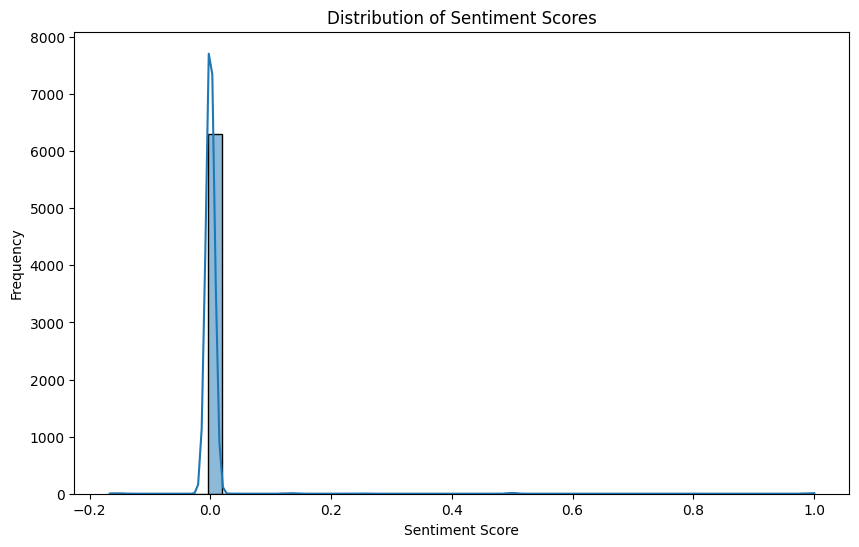

In [133]:
# Perform sentiment analysis on the comments
from textblob import TextBlob

# Calculate sentiment polarity for each post
df['sentiment'] = df['comment'].apply(lambda x: TextBlob(x).sentiment.polarity)

# Plotting the distribution of sentiment scores
plt.figure(figsize=(10, 6))
sns.histplot(df['sentiment'], bins=50, kde=True)
plt.title('Distribution of Sentiment Scores')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.show()

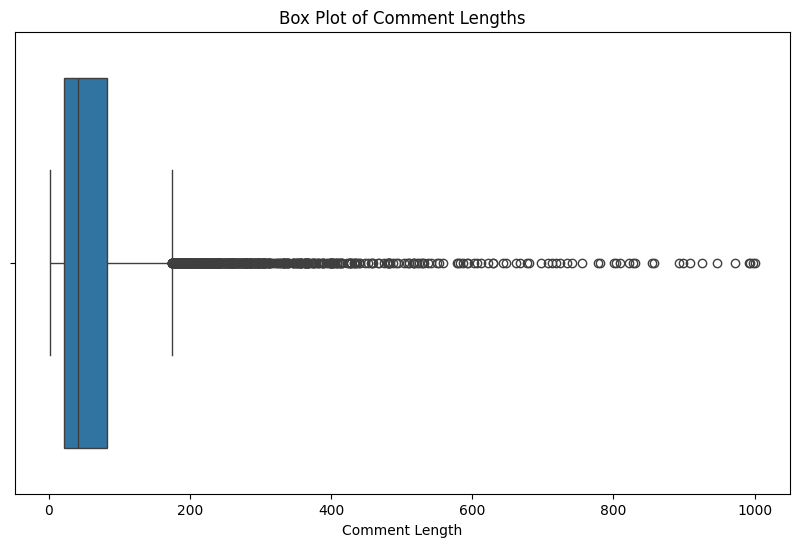

In [135]:
# Calculate the length of each comment
df['comment_length'] = df['comment'].apply(len)

# Plotting a box plot to detect outliers in comment lengths
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['comment_length'])
plt.title('Box Plot of Comment Lengths')
plt.xlabel('Comment Length')
plt.show()

In [136]:
#install fasttext
! pip install fasttext

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.4/73.4 kB 764.4 kB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached pybind11-2.13.5-py3-none-any.whl.metadata (9.5 kB)
Using cached pybind11-2.13.5-py3-none-any.whl (240 kB)
  Created wheel for fasttext: filename=fasttext-0.9.3-cp310-cp310-linux_x86_64.whl size=4246563 sha256=863e8893e506d21a7499ce176ce08ab8993e3cd796587c547441ed21505777f5
  Stored in directory: /root/.cache/pip/wheels/0d/a2/00/81db54d3e6a8199b829d58e02cec2ddb20ce3e59fad8d3c92a
Successfully built fasttext
